# Imports

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import sklearn
import json
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

plt.rcParams.update({'font.size':16})

In [2]:
# Import whole database
with open('../../data/feature_database.json') as json_database:
    database = json.load(json_database)

# Data Formatting

## Economy

In [3]:
# Concat data from sector economy
X_eco_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'economy':
        new_data = pd.read_json(database[i]['data'])
        if X_eco_raw is None:
            X_eco_raw = new_data
        else:
            X_eco_raw = pd.concat([X_eco_raw, new_data], axis=1, join="inner")

X_eco_raw.head()

,ECO_Consumer_Price_Index,ECO_Unemployment_Number,ECO_DAX,ECO_MDAX,ECO_Wholesale_Turnover,ECO_Retail_Sales,ECO_Accommodation,ECO_Hotels_Inns_Guesthouses,ECO_Gastronomy,FuelSale_rohbenzin_tons_insg,FuelSale_rohbenzin_tons_chemWeiterVera,FuelSale_rohbenzin_tons_sonstige
2005-01-01,85.3,5086847,4246.440011,5506.678548,83.5,87.7,79.3,77.7,104.5,1632220,1631127,1093
2005-02-01,85.6,5288245,4344.744019,5737.214453,85.0,83.9,80.5,80.4,99.8,1499439,1497408,2031
2005-03-01,86.0,5266085,4357.401460,5696.047894,98.1,98.3,90.5,89.4,112.1,1550679,1549418,1261
2005-04-01,85.8,5052429,4293.807617,5708.181431,96.3,97.8,99.4,99.0,116.0,1507829,1504132,3697
2005-05-01,85.9,4884238,4329.549139,5751.507302,94.6,94.3,112.7,111.5,122.9,1474656,1471632,3024


In [4]:
X_eco_raw['date'] = X_eco_raw.index
X_eco_raw.date = pd.to_datetime(X_eco_raw.date).dt.to_period('m')
X_eco_raw.index = X_eco_raw.date
X_eco_raw = X_eco_raw.drop('date', axis=1)
X_eco_raw.head()

,ECO_Consumer_Price_Index,ECO_Unemployment_Number,ECO_DAX,ECO_MDAX,ECO_Wholesale_Turnover,ECO_Retail_Sales,ECO_Accommodation,ECO_Hotels_Inns_Guesthouses,ECO_Gastronomy,FuelSale_rohbenzin_tons_insg,FuelSale_rohbenzin_tons_chemWeiterVera,FuelSale_rohbenzin_tons_sonstige
date,,,,,,,,,,,,
2005-01,85.3,5086847,4246.440011,5506.678548,83.5,87.7,79.3,77.7,104.5,1632220,1631127,1093
2005-02,85.6,5288245,4344.744019,5737.214453,85.0,83.9,80.5,80.4,99.8,1499439,1497408,2031
2005-03,86.0,5266085,4357.401460,5696.047894,98.1,98.3,90.5,89.4,112.1,1550679,1549418,1261
2005-04,85.8,5052429,4293.807617,5708.181431,96.3,97.8,99.4,99.0,116.0,1507829,1504132,3697
2005-05,85.9,4884238,4329.549139,5751.507302,94.6,94.3,112.7,111.5,122.9,1474656,1471632,3024


## Mobility

In [5]:
# Concat data from sector mobility
X_mob_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'mobility':
        new_data = pd.read_json(database[i]['data'])
        if X_mob_raw is None:
            X_mob_raw = new_data
        else:
            X_mob_raw = pd.concat([X_mob_raw, new_data], axis=1, join="inner")

X_mob_raw.head()

,M_KFZ,M_SV,M_LV,FuelSale_tons_ottokraftstoff_insg,FuelSale_tons_ottokraftstoff_militaer,FuelSale_tons_ottokraftstoff_sonstige,FuelSale_tons_dieselkraftstoff_insg,FuelSale_tons_dieselkraftstoff_schifffahrt,FuelSale_tons_dieselkraftstoff_militaer,FuelSale_tons_dieselkraftstoff_sonstige,FuelSale_tons_flugkraftstoff_schwer_insg,FuelSale_tons_flugkraftstoff_schwer_luftfahrt,FuelSale_tons_flugkraftstoff_schwer_militaer,FuelSale_tons_flugkraftstoff_schwer_sonstige,M_AviationTotalStartsAndLandings,M_InlandShippingTotalTransportPerformance,M_ShipsGermanFlag,M_ShipsForeignFlag,M_TotalRailFreights
2011-01-01,9.163182e+05,169467.115962,750949.929440,1519000,9157,1509843,2311195,11934,1254,2298007,629657,577369,8650,43638,157923.0,3189,2290912,21139202,8076598488
2011-02-01,9.228540e+05,180239.437819,749058.876655,1427494,8848,1418646,2443433,13238,1263,2428932,579036,522739,13632,42665,156000.0,4363,2029008,17342809,8921846067
2011-03-01,1.016968e+06,213801.934974,810814.414153,1625129,9612,1615517,2823922,16720,1523,2805679,671266,615881,13563,41822,181547.0,5462,2207955,19158437,10551559425
2011-04-01,9.952840e+05,191174.978164,807489.501513,1617986,9745,1608241,2651636,15382,1305,2634949,691378,631931,13229,46218,178565.0,4543,2198525,18988716,9301455105
2011-05-01,1.032499e+06,216044.506250,823418.977051,1789329,9870,1779459,2917399,17289,1080,2899030,738227,670475,15654,52098,198289.0,4326,2784340,20470142,10658822441


In [6]:
X_mob_raw['date'] = X_mob_raw.index
X_mob_raw.date = pd.to_datetime(X_mob_raw.date).dt.to_period('m')
X_mob_raw.index = X_mob_raw.date
X_mob_raw = X_mob_raw.drop('date', axis=1)
X_mob_raw.head()

,M_KFZ,M_SV,M_LV,FuelSale_tons_ottokraftstoff_insg,FuelSale_tons_ottokraftstoff_militaer,FuelSale_tons_ottokraftstoff_sonstige,FuelSale_tons_dieselkraftstoff_insg,FuelSale_tons_dieselkraftstoff_schifffahrt,FuelSale_tons_dieselkraftstoff_militaer,FuelSale_tons_dieselkraftstoff_sonstige,FuelSale_tons_flugkraftstoff_schwer_insg,FuelSale_tons_flugkraftstoff_schwer_luftfahrt,FuelSale_tons_flugkraftstoff_schwer_militaer,FuelSale_tons_flugkraftstoff_schwer_sonstige,M_AviationTotalStartsAndLandings,M_InlandShippingTotalTransportPerformance,M_ShipsGermanFlag,M_ShipsForeignFlag,M_TotalRailFreights
date,,,,,,,,,,,,,,,,,,,
2011-01,9.163182e+05,169467.115962,750949.929440,1519000,9157,1509843,2311195,11934,1254,2298007,629657,577369,8650,43638,157923.0,3189,2290912,21139202,8076598488
2011-02,9.228540e+05,180239.437819,749058.876655,1427494,8848,1418646,2443433,13238,1263,2428932,579036,522739,13632,42665,156000.0,4363,2029008,17342809,8921846067
2011-03,1.016968e+06,213801.934974,810814.414153,1625129,9612,1615517,2823922,16720,1523,2805679,671266,615881,13563,41822,181547.0,5462,2207955,19158437,10551559425
2011-04,9.952840e+05,191174.978164,807489.501513,1617986,9745,1608241,2651636,15382,1305,2634949,691378,631931,13229,46218,178565.0,4543,2198525,18988716,9301455105
2011-05,1.032499e+06,216044.506250,823418.977051,1789329,9870,1779459,2917399,17289,1080,2899030,738227,670475,15654,52098,198289.0,4326,2784340,20470142,10658822441


## Energy and households

In [7]:
# Concat data from sector engergy and households
X_eh_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'energy_households':
        new_data = pd.read_json(database[i]['data'])
        if X_eh_raw is None:
            X_eh_raw = new_data
        else:
            X_eh_raw = pd.concat([X_eh_raw, new_data], axis=1, join="inner")

X_eh_raw.head()

,CO2 of Coal-Energy in (Tonnen),CO2 of Gas in (Tonnen),CO2 of Biomass (Tonnen),CO2 of Hydropower (Tonnen),CO2 of Nuclear (Tonnen),heating_oil_price_in_usd,Deutschland,Deutschland,Deutschland
2007-03-01,20301552.62,2671491.27,355149.122723,49267.728,163265.172,66.790,6.18,63.3,159.6
2007-04-01,18090427.54,2235436.84,334754.479104,39440.736,141627.708,66.350,11.52,4.0,288.8
2007-05-01,17809621.82,2153908.19,356708.400428,47210.808,142169.232,66.615,14.16,131.1,221.6
2007-06-01,17625316.98,2120555.85,333615.733871,53689.536,133340.388,67.545,17.38,108.6,195.2
2007-07-01,18217962.96,1992911.34,368314.387891,55829.616,118069.584,67.335,17.24,121.3,192.3


In [8]:
X_eh_raw['date'] = X_eh_raw.index
X_eh_raw.date = pd.to_datetime(X_eh_raw.date).dt.to_period('m')
X_eh_raw.index = X_eh_raw.date
X_eh_raw = X_eh_raw.drop('date', axis=1)
X_eh_raw.head()

,CO2 of Coal-Energy in (Tonnen),CO2 of Gas in (Tonnen),CO2 of Biomass (Tonnen),CO2 of Hydropower (Tonnen),CO2 of Nuclear (Tonnen),heating_oil_price_in_usd,Deutschland,Deutschland,Deutschland
date,,,,,,,,,
2007-03,20301552.62,2671491.27,355149.122723,49267.728,163265.172,66.790,6.18,63.3,159.6
2007-04,18090427.54,2235436.84,334754.479104,39440.736,141627.708,66.350,11.52,4.0,288.8
2007-05,17809621.82,2153908.19,356708.400428,47210.808,142169.232,66.615,14.16,131.1,221.6
2007-06,17625316.98,2120555.85,333615.733871,53689.536,133340.388,67.545,17.38,108.6,195.2
2007-07,18217962.96,1992911.34,368314.387891,55829.616,118069.584,67.335,17.24,121.3,192.3


## Target Values

In [9]:
# Concat data from target values
Y_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'target_values':
        new_data = pd.read_json(database[i]['data'])
        if Y_raw is None:
            Y_raw = new_data
        else:
            Y_raw = pd.concat([Y_raw, new_data], axis=1, join="inner")

Y_raw.head()

,E_Mio.tonnes_CO2,M_Mio.tonnes_CO2,ECO_Mio.tonnes_CO2,Total_CO2_Emission
1990-01-01,59.831181,11.965386,32.015404,103.811971
1990-02-01,57.338215,12.509267,31.287781,101.135264
1990-03-01,52.352284,13.325089,30.560158,96.237531
1990-04-01,49.859318,14.004941,29.104913,92.969171
1990-05-01,44.873386,14.276881,27.649667,86.799934


In [10]:
Y_raw['date'] = Y_raw.index
Y_raw.date = pd.to_datetime(Y_raw.date).dt.to_period('m')
#Y_raw.to_timestamp('m')
Y_raw.index = Y_raw.date
Y_raw = Y_raw.drop('date', axis=1)
Y_raw.head()

,E_Mio.tonnes_CO2,M_Mio.tonnes_CO2,ECO_Mio.tonnes_CO2,Total_CO2_Emission
date,,,,
1990-01,59.831181,11.965386,32.015404,103.811971
1990-02,57.338215,12.509267,31.287781,101.135264
1990-03,52.352284,13.325089,30.560158,96.237531
1990-04,49.859318,14.004941,29.104913,92.969171
1990-05,44.873386,14.276881,27.649667,86.799934


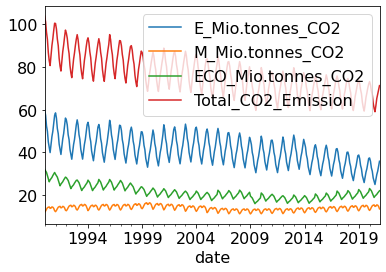

In [11]:
Y_raw.plot()

# Feature correlation

In [12]:
Y = Y_raw[(Y_raw.index.year <= 2017)]

## Economy

In [13]:
Y_eco_train = Y[['ECO_Mio.tonnes_CO2']][(Y.index >= X_eco_raw.index.min())]

X_eco_train = X_eco_raw[(X_eco_raw.index.year <=2017)]

Text(0.5, 1.0, 'Pearson correlation monthly data')

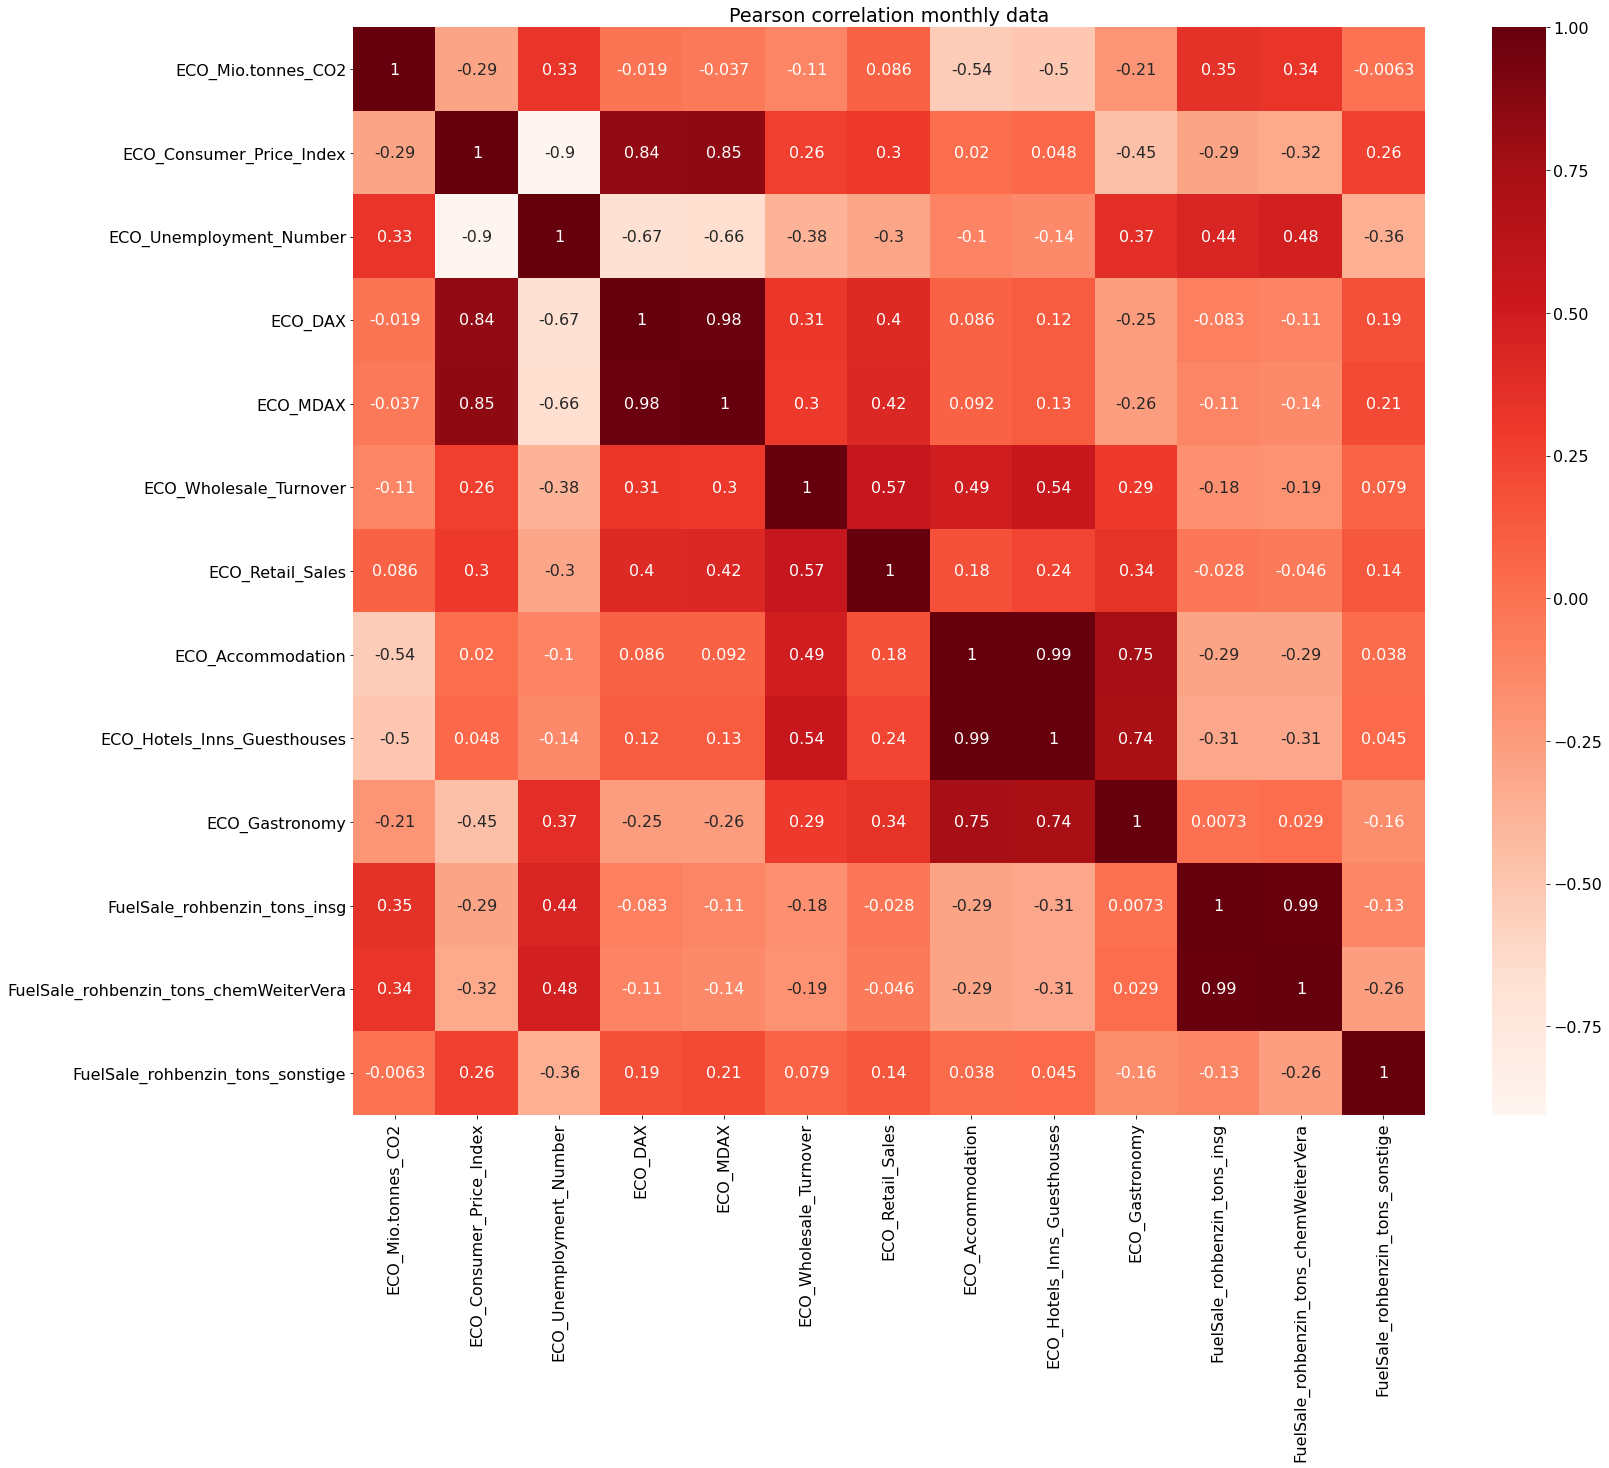

In [14]:
df = pd.concat([Y_eco_train, X_eco_train], axis=1)
plt.figure(figsize=(24,20))
cor = df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title('Pearson correlation monthly data')
#plt.savefig('PearsonCorr_ECO.pdf', format='pdf')

In [15]:
Y_mob_train = Y[['M_Mio.tonnes_CO2']][(Y.index >= X_mob_raw.index.min())]
X_mob_train = X_mob_raw[(X_mob_raw.index.year <=2017)]

Text(0.5, 1.0, 'Pearson correlation monthly data mobility')

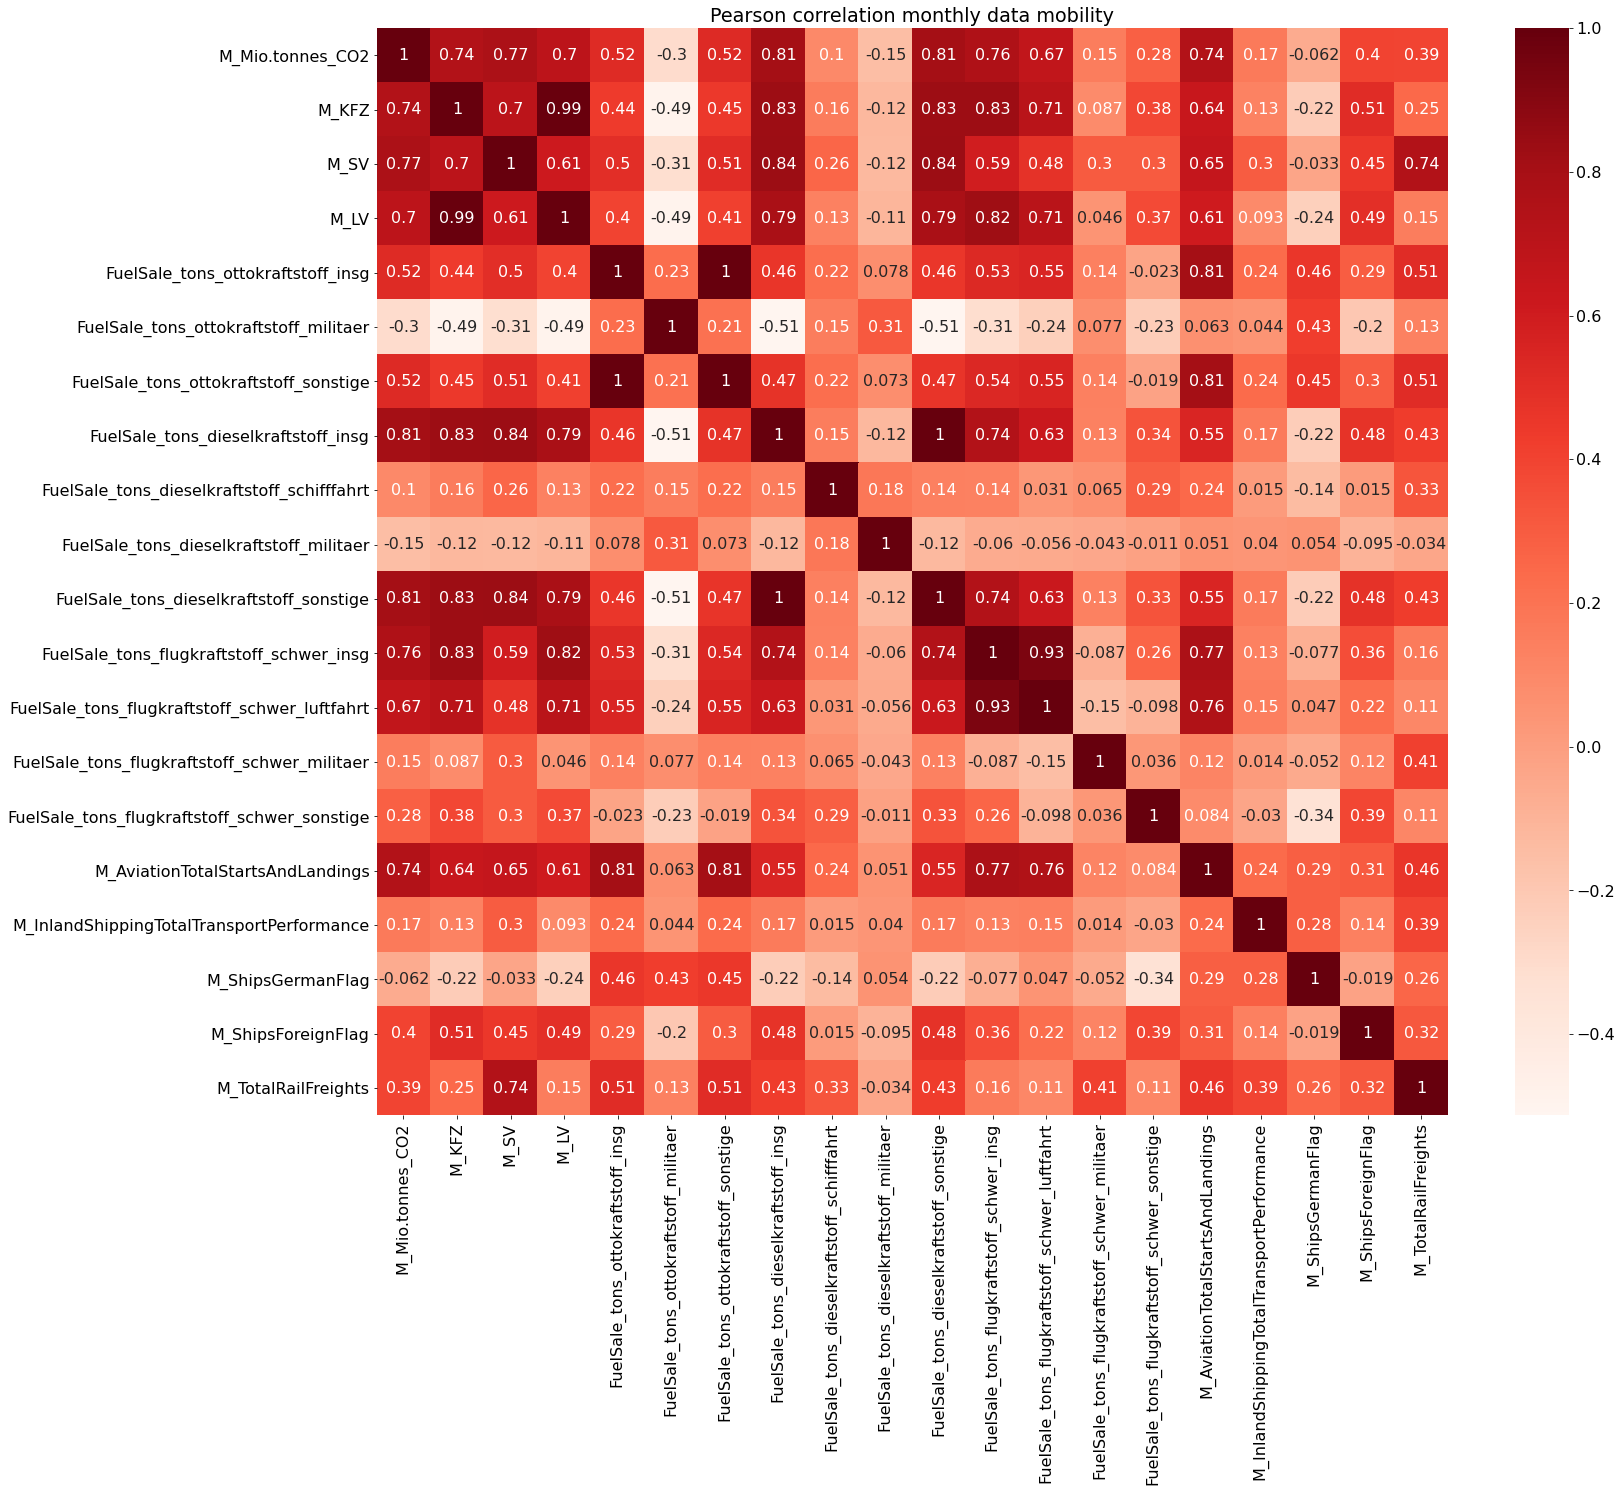

In [16]:
df = pd.concat([Y_mob_train, X_mob_train], axis=1)
plt.figure(figsize=(24,20))
cor = df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title('Pearson correlation monthly data mobility')
#plt.savefig('PearsonCorr_mobility.pdf', format='pdf')

In [17]:
Y_eh_train = Y[['E_Mio.tonnes_CO2']][(Y.index >= X_eh_raw.index.min())]
X_eh_train = X_eh_raw[(X_eh_raw.index.year <=2017)]

Text(0.5, 1.0, 'Pearson correlation monthly data Energy and Household')

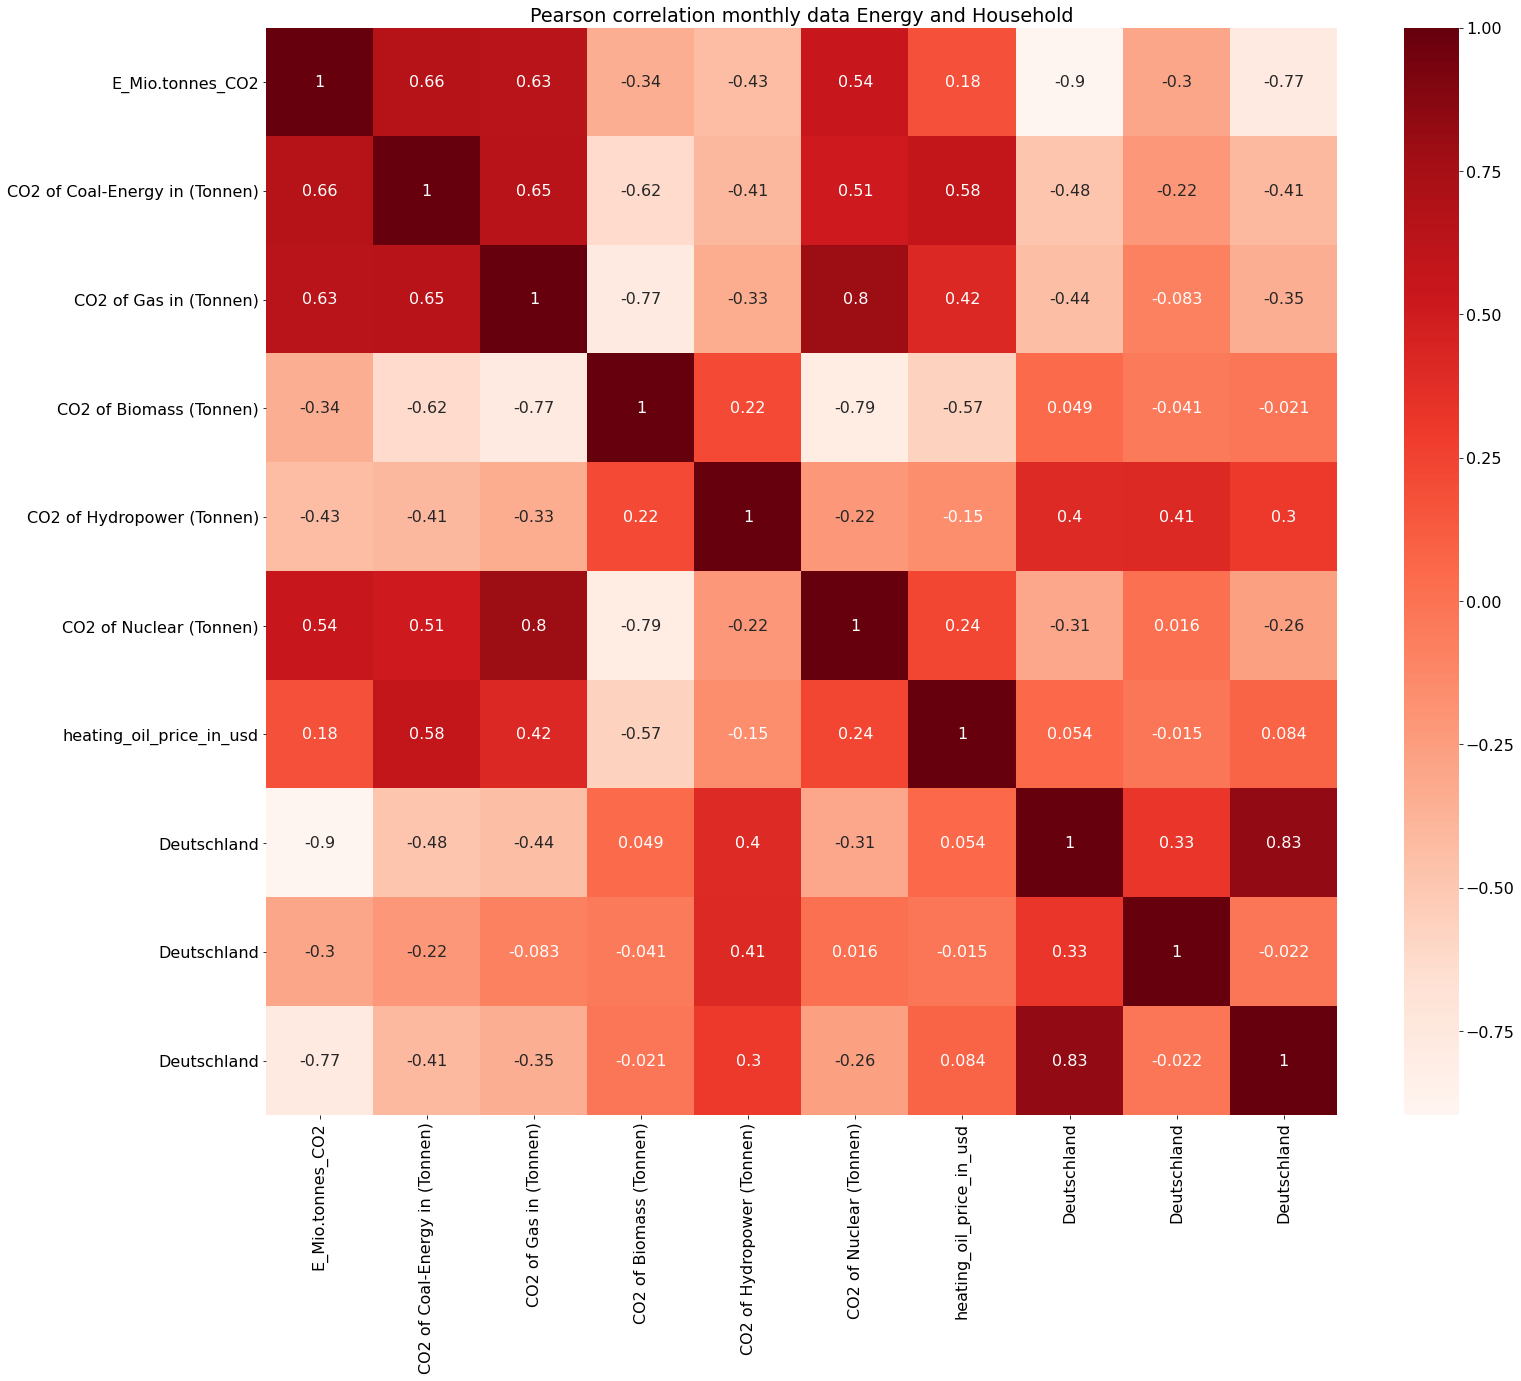

In [18]:
df = pd.concat([Y_eh_train, X_eh_train], axis=1)
plt.figure(figsize=(24,20))
cor = df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title('Pearson correlation monthly data Energy and Household')
#plt.savefig('PearsonCorr_EnergyHousehold.pdf', format='pdf')

# Correlation of features to total amount of CO2

In [19]:
X_train = pd.concat([X_mob_train, X_eco_train, X_eh_train], axis=1)
Y_train = Y[['Total_CO2_Emission']][(Y.index >= X_train.index.min())]

Text(0.5, 1.0, 'Pearson correlation monthly data all data')

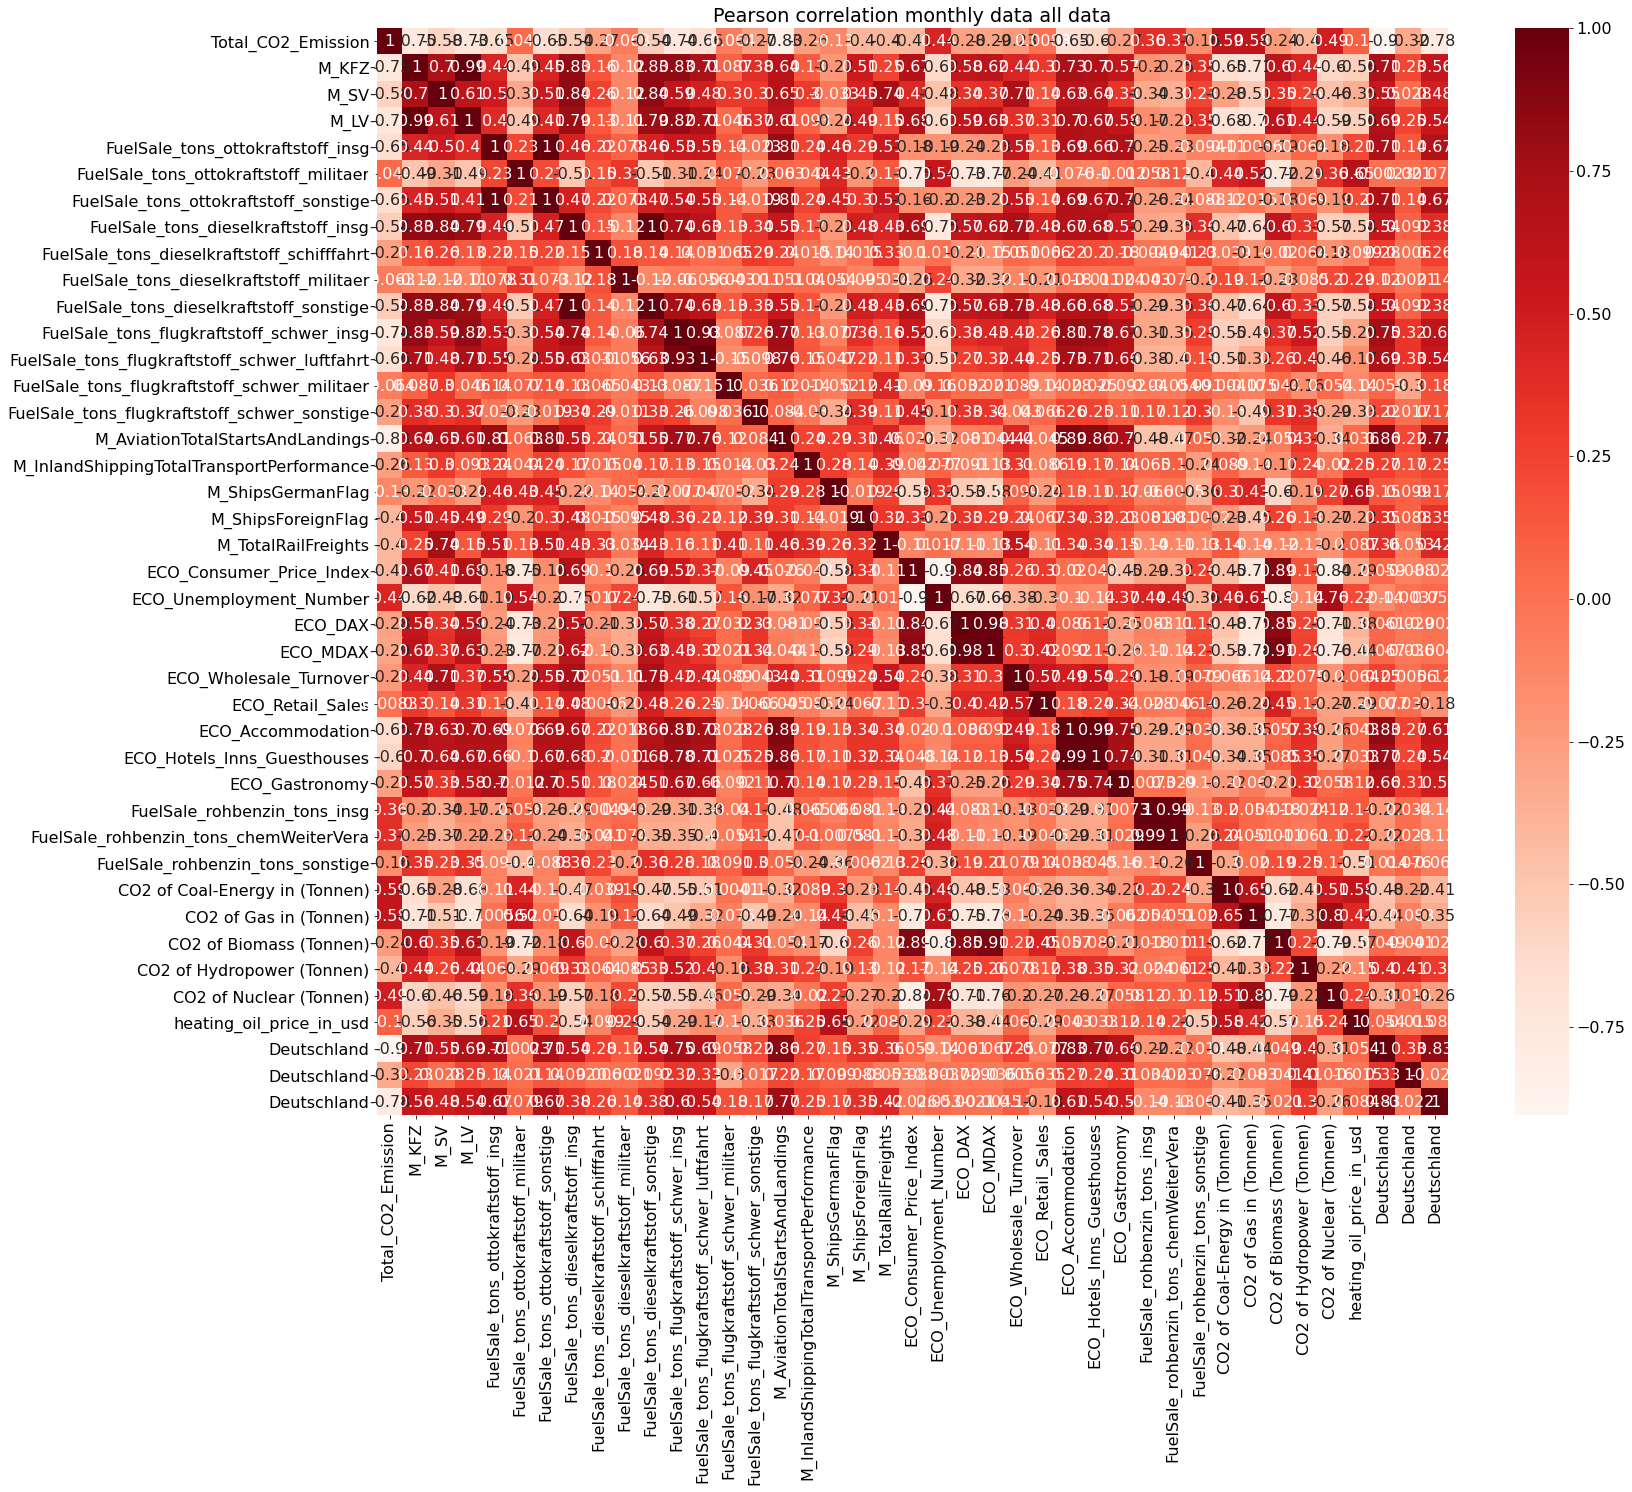

In [20]:
df = pd.concat([Y_train, X_train], axis=1)
plt.figure(figsize=(24,20))
cor = df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title('Pearson correlation monthly data all data')
#plt.savefig('PearsonCorr_EnergyHousehold.pdf', format='pdf')

In [21]:
Y_train = Y[['Total_CO2_Emission']][(Y.index >= X_train.index.min())]

df = X_train
df['CO2'] = Y_train #.values
plt.figure(figsize=(24,20))
cor = df.corr(method='pearson')

df = df.drop('Deutschland', axis=1)
for column in df:
    if column != "CO2":
        df_tmp = pd.DataFrame({column:df[column], 'CO2': df['CO2']},index=df.index)
        
        df_tmp = df_tmp.dropna(axis=0)
        
        print('Pearson r: ' + str(round(pearsonr(df_tmp['CO2'], df_tmp[column])[0],2),) + ', ' + column)

Pearson r: -0.75, M_KFZ
Pearson r: -0.58, M_SV
Pearson r: -0.73, M_LV
Pearson r: -0.65, FuelSale_tons_ottokraftstoff_insg
Pearson r: 0.04, FuelSale_tons_ottokraftstoff_militaer
Pearson r: -0.65, FuelSale_tons_ottokraftstoff_sonstige
Pearson r: -0.54, FuelSale_tons_dieselkraftstoff_insg
Pearson r: -0.27, FuelSale_tons_dieselkraftstoff_schifffahrt
Pearson r: -0.06, FuelSale_tons_dieselkraftstoff_militaer
Pearson r: -0.54, FuelSale_tons_dieselkraftstoff_sonstige
Pearson r: -0.74, FuelSale_tons_flugkraftstoff_schwer_insg
Pearson r: -0.66, FuelSale_tons_flugkraftstoff_schwer_luftfahrt
Pearson r: -0.06, FuelSale_tons_flugkraftstoff_schwer_militaer
Pearson r: -0.27, FuelSale_tons_flugkraftstoff_schwer_sonstige
Pearson r: -0.83, M_AviationTotalStartsAndLandings
Pearson r: -0.26, M_InlandShippingTotalTransportPerformance
Pearson r: -0.13, M_ShipsGermanFlag
Pearson r: -0.4, M_ShipsForeignFlag
Pearson r: -0.4, M_TotalRailFreights
Pearson r: -0.41, ECO_Consumer_Price_Index
Pearson r: 0.44, ECO_Une

<Figure size 1728x1440 with 0 Axes>